## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from facenet_pytorch import MTCNN
import matplotlib.pyplot as plt
import torch

%matplotlib inline


#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

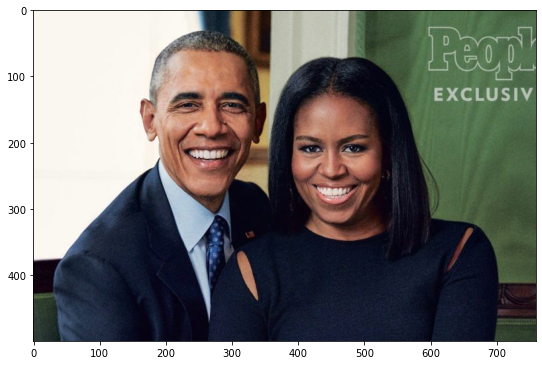

In [3]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


## Haar Cascade

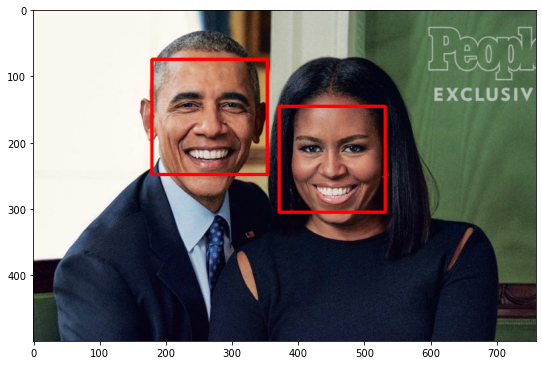

In [4]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

# MTCNN

D:\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<ipython-input-6-6c1f603d71ce>:9: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(image,(x,y),(w,h),(255,0,0),3)


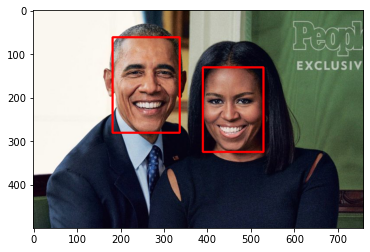

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)

image = cv2.cvtColor(cv2.imread("images/obamas.jpg"),cv2.COLOR_BGR2RGB)

boxes, _ = mtcnn.detect(image)

for (x,y,w,h) in boxes:
    cv2.rectangle(image,(x,y),(w,h),(255,0,0),3) 
plt.imshow(image)

Time taken by Haar Cascade :  0.53125
Time taken by MTCNN :  0.203125


<ipython-input-19-1fe763f68d84>:19: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.rectangle(mtcnn_image,(x,y),(w,h),(255,0,0),3)


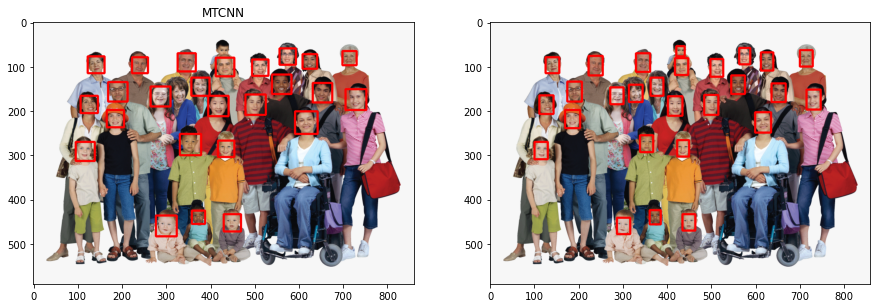

In [19]:
# Test between MTCNN and Haar Cascade
import time

orig_image = cv2.cvtColor(cv2.imread("images/group.png"),cv2.COLOR_BGR2RGB)
haar_image = orig_image.copy()
mtcnn_image = orig_image.copy()

start_haar = time.process_time() 
faces = face_cascade.detectMultiScale(haar_image, 1.2, 2)
end_haar = time.process_time()
for (x,y,w,h) in faces:
    cv2.rectangle(haar_image,(x,y),(x+w,y+h),(255,0,0),3)
print("Time taken by Haar Cascade : ", end_haar - start_haar)

start_mtcnn = time.process_time()    
boxes, _ = mtcnn.detect(mtcnn_image)
end_mtcnn = time.process_time()
for (x,y,w,h) in boxes:
    cv2.rectangle(mtcnn_image,(x,y),(w,h),(255,0,0),3) 
print("Time taken by MTCNN : ", end_mtcnn - start_mtcnn)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (15,15))

ax1.title.set_text('Haar Cascade')
ax1.imshow(haar_image)
ax1.title.set_text('MTCNN')
ax2.imshow(mtcnn_image)


This shows that MTCNN is superior to haar cascades in terms of both accuracy and time taken to detect faces in images. 

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [4]:
import torch
from models import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/22_08_1514.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you'll wrap that Tensor in a Variable() and can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




D:\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


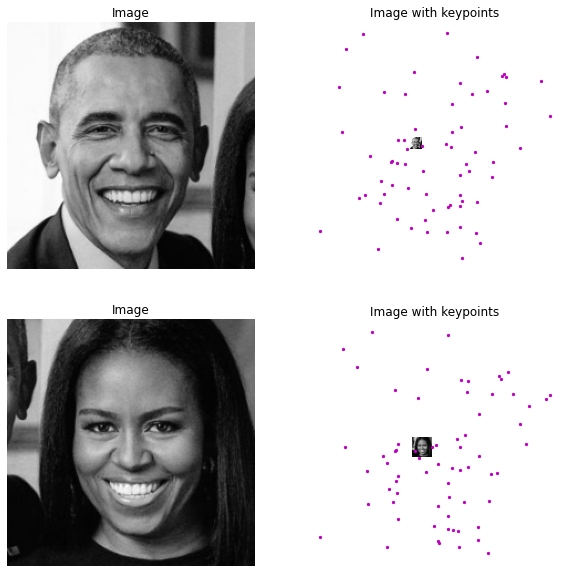

In [5]:
image_copy = np.copy(image)

results = []

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    #roi = image_copy[y:y+h, x:x+w]
    roi = image_copy[y-50:y+h+50, x-50:x+w+50]
    
    ## TODO: Convert the face region from RGB to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    gray_copy = np.copy(gray)
    gray_copy =  gray_copy/255.0
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    output_size = 224
    h, w = gray_copy.shape[:2]
    if isinstance(output_size, int):
        if h > w:
            new_h, new_w = output_size * h / w, output_size
        else:
            new_h, new_w = output_size, output_size * w / h
    else:
        new_h, new_w = output_size

    new_h, new_w = int(new_h), int(new_w)

    img = cv2.resize(gray_copy, (new_w, new_h))
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    img_reshaped = img.reshape(1, 1, new_w, new_h)
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network
    # convert images to FloatTensors
    input_img = torch.tensor(img_reshaped).type(torch.FloatTensor)

    # forward pass to get net output
    output_pts = net(input_img)
    output_pts = output_pts.view(68, -1)
    output_pts = output_pts.detach().numpy()
    # undo normalization of keypoints  
    output_pts = output_pts*50.0+100
    
    results.append((img, output_pts))
    

    ## TODO: Display each detected face and the corresponding keypoints        
    
fig, axs = plt.subplots(len(results), 2, figsize=(10, 10))

for i in range(len(results)):

    im, key_pts = results[i]

    axs[i, 0].imshow(im, cmap = 'gray')
    axs[i, 0].set_title('Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(im, cmap = 'gray')
    axs[i, 1].scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
    axs[i, 1].set_title('Image with keypoints')
    axs[i, 1].axis('off')

plt.show()

In [6]:
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, utils

# # the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
# from data_load import FacialKeypointsDataset
# # the transforms we defined in Notebook 1 are in the helper file `data_load.py`
# from data_load import Rescale, RandomCrop, Normalize, ToTensor

# def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
#     """Show image with predicted keypoints"""
#     # image is grayscale
#     plt.imshow(image, cmap='gray')
#     plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')

# # visualize the output
# # by default this shows a batch of 10 images
# def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=1):

#     for i in range(batch_size):
#         plt.figure(figsize=(20,10))
#         ax = plt.subplot(1, batch_size, i+1)

#         # un-transform the image data
#         image = test_images[i].data   # get the image from it's wrapper
#         image = image.cpu().numpy()   # convert to numpy array from a Tensor
#         image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

#         # un-transform the predicted key_pts data
#         predicted_key_pts = test_outputs[i].data
#         predicted_key_pts = predicted_key_pts.cpu().numpy()
#         # undo normalization of keypoints  
#         predicted_key_pts = predicted_key_pts*50.0+100
        
#         # plot ground truth points for comparison, if they exist
#         ground_truth_pts = None
#         if gt_pts is not None:
#             ground_truth_pts = gt_pts[i]         
#             ground_truth_pts = ground_truth_pts*50.0+100
        
#         plt.imshow(image)
        
#         # call show_all_keypoints
#         show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
#         plt.axis('off')

#     plt.show()
    
    
# # ## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# # # order matters! i.e. rescaling should come before a smaller crop
# # data_transform = transforms.Compose([Rescale(250),
# #                                      RandomCrop(224),
# #                                      Normalize(),
# #                                      ToTensor()])

# image_copy = np.copy(image)
# lol=0
# # loop over the detected faces from your haar cascade
# for (x,y,w,h) in faces:
    
#     # Select the region of interest that is the face in the image 
#     roi = image_copy[y:y+h, x:x+w]
# #     roi = image_copy[y-50:y+h+50, x-50:x+w+50]
    
#     ## TODO: Convert the face region from RGB to grayscale
#     gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

#     ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
#     gray_copy = np.copy(gray)
#     gray_copy =  gray_copy/255.0
    
#     ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
#     output_size = 224
#     h, w = gray_copy.shape[:2]
#     if isinstance(output_size, int):
#         if h > w:
#             new_h, new_w = output_size * h / w, output_size
#         else:
#             new_h, new_w = output_size, output_size * w / h
#     else:
#         new_h, new_w = output_size

#     new_h, new_w = int(new_h), int(new_w)

#     img = cv2.resize(gray_copy, (new_w, new_h))
#     img_reshaped = img.reshape(1, 1, new_w, new_h)
#     input_img = torch.tensor(img_reshaped).type(torch.FloatTensor)
#     output_pts = net(input_img)
#     output_pts = output_pts.view(output_pts.size()[0], 68, -1)
#     visualize_output(input_img, output_pts, None)

# # test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
# #                                              root_dir='data/test/',
# #                                              transform=data_transform)
# # # load test data in batches
# # batch_size = 10

# # test_loader = DataLoader(test_dataset, 
# #                           batch_size=batch_size,
# #                           shuffle=True, 
# #                           num_workers=4)

# # def net_sample_output():
    
# #     # iterate through the test dataset
# #     for i, sample in enumerate(test_loader):
        
# #         # get sample data: images and ground truth keypoints
# #         images = sample['image']
# #         key_pts = sample['keypoints']
        
# #         print(images.shape)
# #         # convert images to FloatTensors
# #         images = images.type(torch.FloatTensor)

# #         # forward pass to get net output
# #         output_pts = net(images)
        
# #         # reshape to batch_size x 68 x 2 pts
# #         output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
# #         # break after first image is tested
# #         if i == 0:
# #             return images, output_pts, key_pts


    
# # test_images, test_outputs, gt_pts = net_sample_output()
# # visualize_output(test_images, test_outputs, gt_pts)

In [7]:
# image_copy = np.copy(image)
# from torch.autograd import Variable
# # helper fuction to plot images
# def showpoints(image,keypoints):
    
#     plt.figure()
    
#     keypoints = keypoints.data.numpy()
#     keypoints = keypoints * 60.0 + 68
#     keypoints = np.reshape(keypoints, (68, -1))
    
#     plt.imshow(image, cmap='gray')
#     plt.scatter(keypoints[:, 0], keypoints[:, 1], s=50, marker='.', c='r')


    
#     from torch.autograd import Variable
    
# image_copy = np.copy(image)


# # loop over the detected faces from your haar cascade
# for (x,y,w,h) in faces:
    
#     # Select the region of interest that is the face in the image 
#     roi = image_copy[y:y+h,x:x+w]

#     ## TODO: Convert the face region from RGB to grayscale
    
#     #gray= cv2.cvtColor(roi , cv2.COLOR_BGR2RGB)plt.imshow(gray)gray =  cv2.cvtColor( roi, cv2.COLOR_RGB2GRAY)
#     roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
#     #plt.imshow(roi,cmap = 'gray')
#     #plt.imshow(roi)
#     image = roi

#     ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
#     roi = roi/255.0
    
#     ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
#     roi = cv2.resize(roi, (224,224))
#     #roi = roi.reshape(roi.shape[0], roi.shape[1], 1)
    
# #     plt.imshow(roi,cmap='gray')
#     ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
#     roi = np.expand_dims(roi, 0)
#     roi = np.expand_dims(roi, 0)
#     input_img = torch.tensor(roi).type(torch.FloatTensor)
    
#     with torch.no_grad():
#         output_pts = net(input_img)
#     output_pts = output_pts.view(68, -1)
#     output_pts = output_pts.detach().numpy()
#     # undo normalization of keypoints  
#     output_pts = output_pts*50.0+100
# # #################
#     plt.scatter(output_pts[:, 0], output_pts[:, 1], s=40, marker='.', c='m')
    

    
# #     ## TODO: Make facial keypoint predictions using your loaded, trained network 
# #     #net.visualize_output(roi, test_outputs, gt_pts=None, batch_size=10)
# #     roi_torch = Variable(torch.from_numpy(roi))
    
# #     roi_torch = roi_torch.type(torch.FloatTensor)
# #     keypoints = net(roi_torch)
# #     print(keypoints.shape)
    
#     #####################

#     ## TODO: Display each detected face and the corresponding keypoints        
# #     showpoints(image,output_pts)

In [8]:
# def show_all_keypoints(image, predicted_key_pts):
#     """Show image with predicted keypoints"""
#     # image is grayscale
#     plt.imshow(image, cmap='gray')
#     plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')

# def visualize_output(test_images, test_outputs):

#     plt.figure(figsize=(20,10))
#     ax = plt.subplot(1, 1, 1)

#     # un-transform the image data
#     image = test_images   # get the image from it's wrapper
#     image = image.cpu().numpy()   # convert to numpy array from a Tensor
#     image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

#     # un-transform the predicted key_pts data
#     predicted_key_pts = test_outputs[i].data
#     predicted_key_pts = predicted_key_pts.cpu().numpy()
#     # undo normalization of keypoints  
#     predicted_key_pts = predicted_key_pts*50.0+100

#     # call show_all_keypoints
#     show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)

#     plt.axis('off')

#     plt.show()
    
        
# image_copy = np.copy(image)

# # loop over the detected faces from your haar cascade
# for (x,y,w,h) in faces:
    
#     # Select the region of interest that is the face in the image 
#     #roi = image_copy[y:y+h, x:x+w]
#     roi = image_copy[y-50:y+h+50, x-50:x+w+50]
    
#     ## TODO: Convert the face region from RGB to grayscale
#     gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

#     ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
#     gray_copy = np.copy(gray)
#     gray_copy =  gray_copy/255.0
    
#     ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
#     output_size = 224
#     h, w = gray_copy.shape[:2]
#     if isinstance(output_size, int):
#         if h > w:
#             new_h, new_w = output_size * h / w, output_size
#         else:
#             new_h, new_w = output_size, output_size * w / h
#     else:
#         new_h, new_w = output_size

#     new_h, new_w = int(new_h), int(new_w)

#     img = cv2.resize(gray_copy, (new_w, new_h))
    
#     ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
#     img_reshaped = img.reshape(1, 1, new_w, new_h)
    
#     ## TODO: Make facial keypoint predictions using your loaded, trained network
#     # convert images to FloatTensors
#     input_img = torch.tensor(img_reshaped).type(torch.FloatTensor)
    
        
#     # get sample data: images and ground truth keypoints
#     images = input_img[0]

#     # convert images to FloatTensors
#     images = images.type(torch.FloatTensor)

#     # forward pass to get net output
#     with torch.no_grad():
#         output_pts = net(images[None,:,:,:])

#     # reshape to batch_size x 68 x 2 pts
#     output_pts = output_pts.view(output_pts.size()[0], 68, -1)

#     predicted_key_pts = output_pts*50.0+100

# #     # call show_all_keypoints
#     show_all_keypoints(np.squeeze(roi), predicted_key_pts)
#     print(output_pts)

In [9]:
# image_copy = np.copy(image)

# results = []

# # loop over the detected faces from your haar cascade
# for (x,y,w,h) in faces:
    
#     # Select the region of interest that is the face in the image 
#     #roi = image_copy[y:y+h, x:x+w]
#     roi = image_copy[y-50:y+h+50, x-50:x+w+50]
    
#     ## TODO: Convert the face region from RGB to grayscale
#     gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)

#     ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
#     gray_copy = np.copy(gray)
#     gray_copy =  gray_copy/255.0
    
#     ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
#     output_size = 224
#     h, w = gray_copy.shape[:2]
#     if isinstance(output_size, int):
#         if h > w:
#             new_h, new_w = output_size * h / w, output_size
#         else:
#             new_h, new_w = output_size, output_size * w / h
#     else:
#         new_h, new_w = output_size

#     new_h, new_w = int(new_h), int(new_w)

#     img = cv2.resize(gray_copy, (new_w, new_h))
    
#     ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
#     img_reshaped = img.reshape(1, 1, new_w, new_h)
    
#     ## TODO: Make facial keypoint predictions using your loaded, trained network
#     # convert images to FloatTensors
#     input_img = torch.tensor(img_reshaped).type(torch.FloatTensor)
    
#     print(input_img.shape)

#     # forward pass to get net output
#     output_pts = net(input_img)
#     output_pts = output_pts.view(68, -1)
#     output_pts = output_pts.detach().numpy()
#     # undo normalization of keypoints  
#     output_pts = output_pts*50.0+100
    
#     results.append((img, output_pts))
    

#     ## TODO: Display each detected face and the corresponding keypoints        
    
# fig, axs = plt.subplots(len(results), 2, figsize=(10, 10))

# for i in range(len(results)):

#     im, key_pts = results[i]

#     axs[i, 0].imshow(im, cmap = 'gray')
#     axs[i, 0].set_title('Image')
#     axs[i, 0].axis('off')

#     axs[i, 1].imshow(im, cmap = 'gray')
#     axs[i, 1].scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
#     axs[i, 1].set_title('Image with keypoints')
#     axs[i, 1].axis('off')

# plt.show()